In [1]:
import numpy as np
import h5py
import os
import glob
from utilityFunctions import load_csv_to_matrix, load_csv_to_matrix_batch, compute_color_preference_raw_batch, compute_color_preference_distance_batch, show_heatmaps, compute_color_similarity_distance_batch, compute_correlations, RSA, split_and_average_matrices, perform_mds_and_plot

In [2]:
unique_colours = np.array(['#d2b700', '#db8b08', '#c7512c', '#c13547', '#a03663', '#753a7a', '#4b488e', '#005692', '#006a8b', '#007b75', '#008a52', '#9aa400'])
colour_index = {colour: idx for idx, colour in enumerate(unique_colours)}
matrix_size = len(unique_colours)
folder_path = 'raw_data/202411_data'
response_type = 'preference'

In [3]:
def load_clusters_from_mat_v73(file_path):
    with h5py.File(file_path, 'r') as f:
        print("Keys:", list(f.keys()))  # Inspect available variables

        clusters = f['clusters']
        # Assume it's a 2x1 cell array, and each cell points to a dataset
        cluster1_ref = clusters[0][0]
        cluster2_ref = clusters[1][0]

        cluster1 = np.array(f[cluster1_ref]).astype(int).flatten()
        cluster2 = np.array(f[cluster2_ref]).astype(int).flatten()

        return cluster1, cluster2


In [4]:
cluster1, cluster2 = load_clusters_from_mat_v73('raw_data/clusters_preference_raw.mat')
print(cluster1)
print(cluster2)

Keys: ['#refs#', 'clusters', 'participants', 'process_type', 'rating_type']
[ 1 15 12  7 11  5  8 10  4 13 18]
[ 2 19  6  3 16  9 14 17]


In [5]:
cluster_1_matrices = []
for subject_id in cluster1:
    # Construct glob pattern
    subject_pattern = f"subject_{subject_id:02d}_*.csv"
    search_path = os.path.join(folder_path, subject_pattern)

    matched_files = glob.glob(search_path)

    if not matched_files:
        print(f"No file found for subject {subject_id}")
        continue  # Skip if no match

    file_path = matched_files[0]  # Use the first match
    matrix = load_csv_to_matrix(file_path, response_type, colour_index, matrix_size)
    cluster_1_matrices.append(matrix)

cluster_1_matrices_raw_preference = compute_color_preference_raw_batch(cluster_1_matrices, value_range_max = 3.5)

cluster_2_matrices = []
for subject_id in cluster2:
    # Construct glob pattern
    subject_pattern = f"subject_{subject_id:02d}_*.csv"
    search_path = os.path.join(folder_path, subject_pattern)

    matched_files = glob.glob(search_path)

    if not matched_files:
        print(f"No file found for subject {subject_id}")
        continue  # Skip if no match

    file_path = matched_files[0]  # Use the first match
    matrix = load_csv_to_matrix(file_path, response_type, colour_index, matrix_size)
    cluster_2_matrices.append(matrix)

cluster_2_matrices_raw_preference = compute_color_preference_raw_batch(cluster_2_matrices, value_range_max = 3.5)

In [6]:
len(cluster_2_matrices_raw_preference)

8

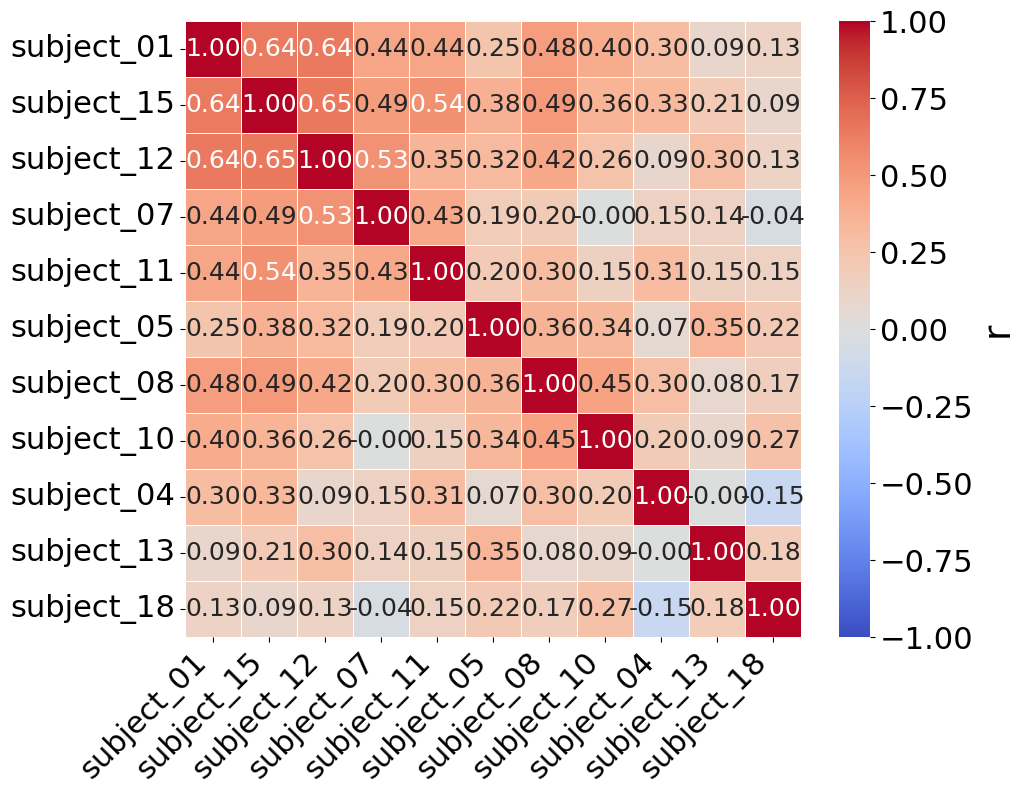

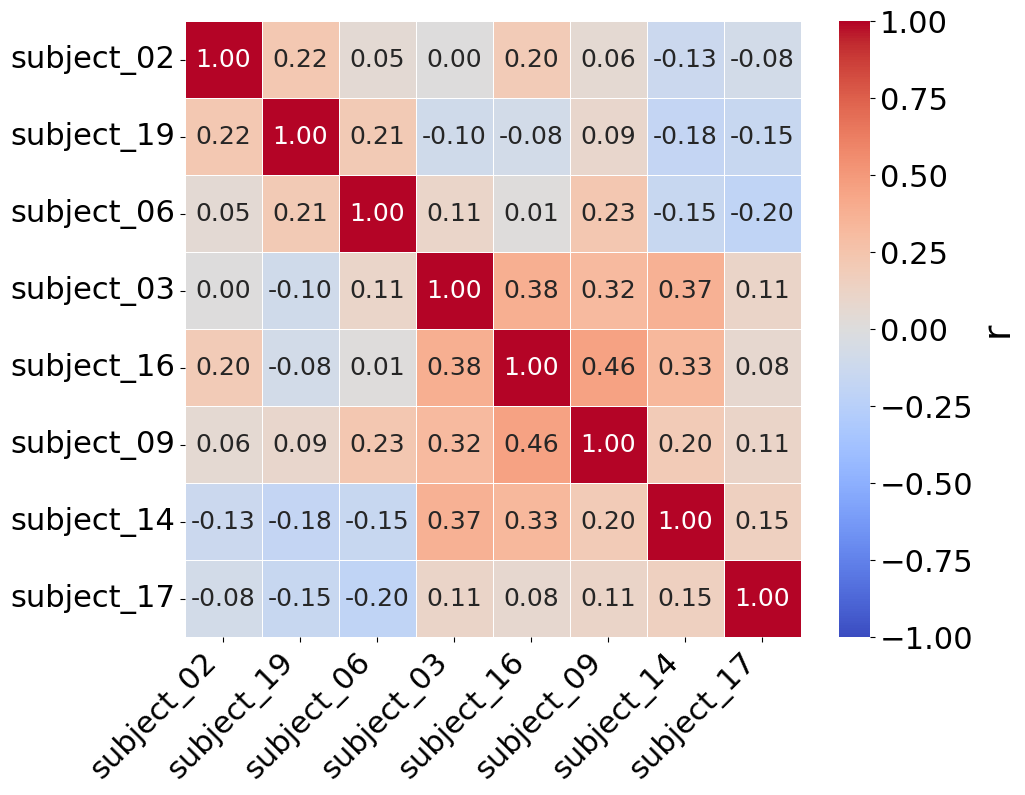

(array([[ 1.        ,  0.2249494 ,  0.05435882,  0.00201833,  0.20202268,
          0.06021558, -0.12756458, -0.07826668],
        [ 0.2249494 ,  1.        ,  0.2089132 , -0.09598502, -0.08024734,
          0.08786534, -0.17755183, -0.14978123],
        [ 0.05435882,  0.2089132 ,  1.        ,  0.10654159,  0.01063501,
          0.23021626, -0.15232175, -0.19907718],
        [ 0.00201833, -0.09598502,  0.10654159,  1.        ,  0.3836023 ,
          0.31561013,  0.37097386,  0.11002907],
        [ 0.20202268, -0.08024734,  0.01063501,  0.3836023 ,  1.        ,
          0.45788285,  0.32827788,  0.07644436],
        [ 0.06021558,  0.08786534,  0.23021626,  0.31561013,  0.45788285,
          1.        ,  0.20251521,  0.109453  ],
        [-0.12756458, -0.17755183, -0.15232175,  0.37097386,  0.32827788,
          0.20251521,  1.        ,  0.15235775],
        [-0.07826668, -0.14978123, -0.19907718,  0.11002907,  0.07644436,
          0.109453  ,  0.15235775,  1.        ]]),
 ['subject_02'

In [7]:
cluster1_dict = {f"subject_{i:02d}": m for i, m in zip(cluster1, cluster_1_matrices_raw_preference)}
cluster2_dict = {f"subject_{i:02d}": m for i, m in zip(cluster2, cluster_2_matrices_raw_preference)}

compute_correlations(cluster1_dict)
compute_correlations(cluster2_dict)

In [8]:
stacked_1 = np.stack(cluster_1_matrices_raw_preference)  # Shape: (n_subjects, matrix_size, matrix_size)
cluster_1_mean_raw_preference = np.mean(stacked_1, axis=0)

stacked_2 = np.stack(cluster_2_matrices_raw_preference)  
cluster_2_mean_raw_preference = np.mean(stacked_2, axis=0)

In [9]:
cluster_2_mean_raw_preference.shape

(12, 12)

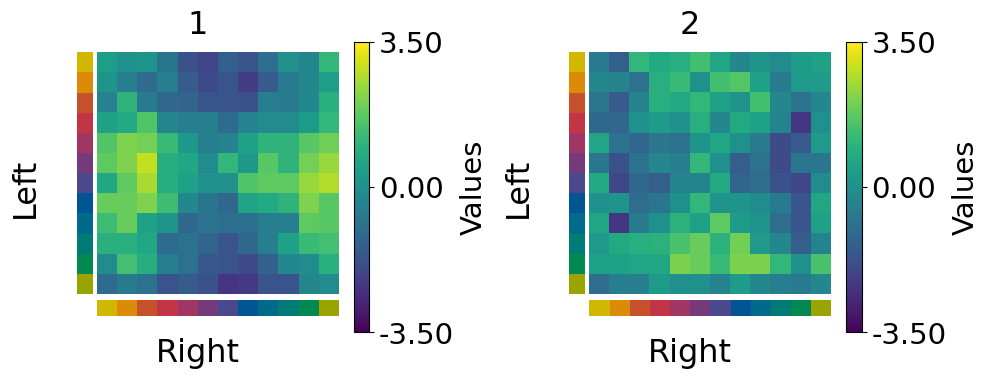

In [10]:
show_heatmaps(vmin_val=-3.5, vmax_val=3.5, matrices=[cluster_1_mean_raw_preference, cluster_2_mean_raw_preference], titles=list(range(1, 3)), nrows=1, ncols=2, cmap_name="viridis", cbar_label="Values", color_labels=unique_colours)

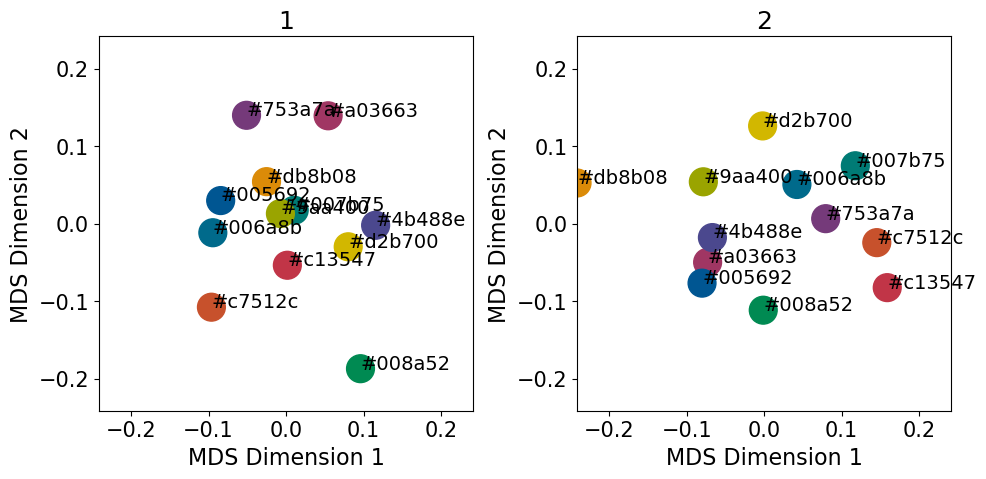

In [11]:
perform_mds_and_plot(matrices = [cluster_1_mean_raw_preference, cluster_2_mean_raw_preference], titles = list(range(1, 3)), colour_index = colour_index, n_rows = 1, n_cols = 2, n_components=2)